In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 11:27:35.764122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 11:27:37.384611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 11500
end_idx = 12000
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(500, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(500, 96, 7)
(336000,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(500, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(500, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 11:27:46.815694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 11:27:50.171783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step
CPU time: 7608.3753221940715 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

16/16 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.21001068 0.46841673 0.90274971 ... 0.83974531 0.03947671 0.59527323]
Fitness value of the best solution = 0.0010415896431259447


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

16/16 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


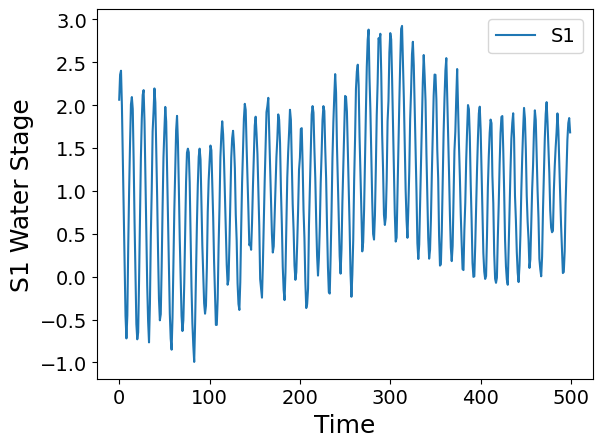

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low14.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.210011,0.468417,0.902750,0.930480,0.530994,0.143157,0.652455,0.753911,0.292904,0.451043,...,0.547187,0.428904,0.233548,0.398035,0.505277,0.167248,0.063439,0.073394,0.233994,0.192441
1,0.641001,0.497240,0.552925,0.774298,0.801182,0.791027,0.978656,0.616305,0.489569,0.061395,...,0.782278,0.279281,0.760499,0.710176,0.496726,0.114730,0.314785,0.336831,0.879504,0.950767
2,0.317216,0.298318,0.272757,0.025676,0.316448,0.546270,0.212143,0.328240,0.815399,0.017987,...,0.883400,0.617996,0.591897,0.370927,0.332571,0.253309,0.386957,0.810458,0.566964,0.142242
3,0.678888,0.169898,0.298890,0.711881,0.132555,0.904617,0.078257,0.475388,0.559909,0.912583,...,0.275972,0.488862,0.634728,0.705299,0.363144,0.953365,0.180892,0.515642,0.616032,0.792305
4,0.562990,0.661839,0.580893,0.802914,0.890074,0.103249,0.154054,0.712363,0.464933,0.890890,...,0.800245,0.603867,0.332562,0.412989,0.060433,0.617658,0.132811,0.783561,0.013001,0.715673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.943766,0.674956,0.802562,0.520936,0.248542,0.567962,0.640614,0.218140,0.042055,0.028316,...,0.929647,0.745505,0.800525,0.320249,0.729541,0.644087,0.292238,0.849473,0.834320,0.235592
496,0.623381,0.339317,0.244701,0.317492,0.239319,0.340523,0.021423,0.935451,0.062404,0.241676,...,0.702079,0.443291,0.738012,0.003117,0.886618,0.412866,0.556173,0.999449,0.482992,0.698533
497,0.224357,0.317869,0.944015,0.094580,0.408647,0.811513,0.831502,0.891273,0.138100,0.392050,...,0.038376,0.955949,0.869574,0.426881,0.801499,0.631757,0.214001,0.563447,0.255019,0.636940
498,0.168130,0.816418,0.265783,0.749377,0.566828,0.052720,0.848426,0.340727,0.020827,0.372846,...,0.652213,0.098339,0.755584,0.026648,0.574532,0.132340,0.931074,0.168741,0.379124,0.014812


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low14.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.063379,2.317789,2.086383,2.185695,2.408437,2.541138,2.270622,2.443038,2.664224,2.621822,...,-0.347291,-0.490263,-0.105655,0.082038,-0.037943,-0.014514,0.511048,0.531316,0.475835,0.563112
1,2.355569,2.535864,2.302869,2.433670,2.479846,2.719957,2.386434,2.519875,2.079792,2.465405,...,0.045174,-0.042966,0.599701,0.703786,0.617321,0.682508,1.190898,1.325996,1.148340,1.256917
2,2.401264,2.819856,2.511639,2.578415,2.026433,2.263063,2.072422,2.177949,1.450728,1.213597,...,0.742473,0.751953,1.192480,1.063692,1.240595,1.315595,1.676095,1.566306,1.609603,1.738216
3,1.995376,2.208634,2.076718,2.150454,1.466668,1.518902,1.497137,1.691723,0.593439,0.507196,...,1.091088,1.204073,1.746486,1.782910,1.741840,1.839836,2.087815,2.183624,2.078027,2.188507
4,1.379046,1.258167,1.394406,1.416184,0.727250,1.020693,0.739447,0.835451,-0.002978,0.003500,...,1.625540,1.729342,2.186450,2.162609,2.178883,2.246509,2.144456,2.196087,2.095145,2.221337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.236504,1.204987,1.291828,1.295456,1.615642,1.497003,1.656342,1.676297,1.918539,1.565248,...,0.227512,0.123473,0.136336,0.420631,0.239962,0.183303,0.318151,0.386306,0.466741,0.482313
496,1.597723,1.411888,1.566430,1.618171,1.975686,1.896849,1.908815,2.079031,1.935968,1.806674,...,0.206390,0.132342,0.336348,0.621231,0.548370,0.491767,0.709518,0.631821,0.858644,0.910209
497,1.790184,1.847933,1.895194,1.904261,1.946272,2.177295,1.986771,2.029027,1.597435,1.905424,...,0.394789,0.364463,0.668086,0.618784,0.695835,0.772199,1.034557,1.165645,1.054060,1.118563
498,1.849259,2.013103,1.874406,1.998949,1.709984,1.993281,1.735536,1.882653,1.465865,1.815041,...,0.775066,0.793970,1.067617,1.142741,1.188790,1.210409,1.255590,1.177505,1.256639,1.348059


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 3235, areas: 887.2347760184557


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

16/16 [==============================] - 0s 3ms/step
time steps: 0, areas: 0
time steps: 7242, areas: 2434.760455945754
